# Bayesian approaches

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from sklearn.model_selection import train_test_split

In [2]:
# Import data
covid_df = pd.read_csv('../data/cleaned_05-29-2020.csv', index_col=0)

In [3]:
# Split into predictors and response
not_x = ['q_popdensity', 'fips', 'Deaths']
x_cols = [col for col in covid_df.columns if col not in not_x]
X = covid_df[x_cols]
y = covid_df['Deaths']

In [4]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15)

In [5]:
# Split up X_train columns into relevant model predictors
x_state = X_train['state'].values
x_confirmed = X_train['Confirmed'].values
x_pm25 = X_train['mean_pm25'].values
x_den = X_train['popdensity'].values
x_old = X_train['older_percent'].values
x_pov = X_train['poverty'].values
x_mhi = np.log(X_train['medhouseholdincome']).values
x_blk = X_train['pct_blk'].values
x_his = X_train['hispanic'].values
x_edu = X_train['education'].values
x_mhv = np.log(X_train['medianhousevalue']).values
x_occ = X_train['pct_owner_occ'].values
x_obe = X_train['obese'].values
x_smk = X_train['smoke'].values
x_bed = X_train['beds'].values
x_mst = X_train['mean_summer_temp'].values
x_mwt = X_train['mean_winter_temp'].values
x_msh = X_train['mean_summer_rm'].values
x_mwh = X_train['mean_winter_rm'].values
x_tot = X_train['total'].values
x_pop = X_train['Population'].values
x_lat = X_train['Lat'].values
x_lon = X_train['Long'].values

## Model 1. P1 (a la MacLehose)

We propose a model that the number of deaths in county $i$, $y_i$, follows a negative binomial regression model with mean $\mu_i$ and Gamma parameter $\alpha$, such that $y_i \sim \textrm{NBin} (\mu_i, \alpha)$. We also assume a uniform prior for $\alpha$, and that: $$\mu_i = c_i \exp \eta_i, \eta_i = \beta_{0j} + \sum_k \beta_k x_{ik}$$
Where $c_i$ is the population of county $i$. We assume a random intercept based on state $j$ where $\beta_{0j} \sim \mathcal{N} (0, \sigma_0)$ are drawn from the same normal distribution (since Wu et al. showed that counties within the same state are correlated with one another). We assume a Uniform prior for $\sigma_0$. Furthermore, let $\beta_{k} \sim \mathcal{N} (\mu_k, \sigma_k)$ priors be draws from a normal distribution for each of the predictors $k$, and let $\mathbf{x}_{i} = (x_{i1}, x_{i2} \dots x_{ik}, \dots x_{i 21})$ be a $20$-dimensional vector whose components correspond to the predictors:
1. Mean PM2.5
2. Population density
3. Percent $\geq 65$
4. Poverty
5. Median household income
6. Percent black
7. Percent hispanic
8. Percent with less than a high school education
9. Median home value
10. Percent owner-occupied housing
11. Obesity rate
12. Smoking rate
13. Number of beds available
14. Mean summer temperature
15. Mean winter temperature
16. Mean summer relative humidity
17. Mean winter relative humidity
18. $\log $ population size
19. Latitude
20. Longitude
21. Total number of tests performed in the state

According to MacLehose, for the first type of model P1, you don't inform yourself of what the priors of the coefficients might be, so we assume a normal prior centered at $0$ with standard deviation $100$ for each of the coefficients, as is standard.

In [6]:
# Fit model to training data
with pm.Model() as p1_model:
    
    # Priors for random intercept
    sigma_0 = pm.Uniform('sigma_0', 0, 10)
    beta_0 = pm.Normal('beta_0', mu=np.repeat(0,len(set(x_state))), 
                       sd=np.repeat(sigma_0,len(set(x_state))), shape=len(set(x_state)))
    
    # Priors for linear terms
    beta_pm25 = pm.Normal('beta_pm25', mu=0, sd=100) #Pm2.5 
    beta_den = pm.Normal('beta_den', mu=0, sd=100)   #Population density
    beta_old = pm.Normal('beta_old', mu=0, sd=100)   #Older percent
    beta_pov = pm.Normal('beta_pov', mu=0, sd=100)   #Poverty rate
    beta_mhi = pm.Normal('beta_mhi', mu=0, sd=100)   #Med hh income
    beta_blk = pm.Normal('beta_blk', mu=0, sd=100)   #Percent black
    beta_his = pm.Normal('beta_his', mu=0, sd=100)   #Percent hispanic
    beta_edu = pm.Normal('beta_edu', mu=0, sd=100)   #Percent with less than HS education
    beta_mhv = pm.Normal('beta_mhv', mu=0, sd=100)   #Med home value
    beta_occ = pm.Normal('beta_occ', mu=0, sd=100)   #Percent owner-occupied housing
    beta_obe = pm.Normal('beta_obe', mu=0, sd=100)   #Obesity
    beta_smk = pm.Normal('beta_smk', mu=0, sd=100)   #Smoke rate
    beta_bed = pm.Normal('beta_bed', mu=0, sd=100)   #N. beds
    beta_mst = pm.Normal('beta_mst', mu=0, sd=100)   #Mean summer temperature
    beta_mwt = pm.Normal('beta_mwt', mu=0, sd=100)   #Mean winter temprerature
    beta_msh = pm.Normal('beta_msh', mu=0, sd=100)   #Mean summer relative humidity
    beta_mwh = pm.Normal('beta_mwh', mu=0, sd=100)   #Mean winter relative humditiy
    beta_lat = pm.Normal('beta_lat', mu=0, sd=100)   #Latitude
    beta_lon = pm.Normal('beta_lon', mu=0, sd=100)   #Longitude
    beta_tot = pm.Normal('beta_tot', mu=0, sd=100)   #Total n. tests

    # Finding eta
    eta = beta_0[x_state] + beta_pm25*x_pm25 + beta_den*x_den + beta_old*x_old + beta_pov*x_pov \
            + beta_pov*x_pov + beta_mhi*x_mhi + beta_blk*x_blk + beta_his*x_his + beta_edu*x_edu \
            + beta_mhv*x_mhv + beta_occ*x_occ + beta_obe*x_obe + beta_smk*x_smk + beta_bed*x_bed \
            + beta_mst*x_mst + beta_mwt*x_mwt + beta_msh*x_msh + beta_mwh*x_mwh + beta_lat*x_lat \
            + beta_lon*x_lon + beta_tot*x_tot
    
    # Prior for spread
    alpha = pm.Uniform('alpha', 0, 100)
    
    # Sample from Negative Binomial distribution to find number of deaths
    y_obs = pm.distributions.discrete.NegativeBinomial('y_obs', mu=x_pop*np.exp(eta), 
                                                       alpha=alpha, observed=y_train)

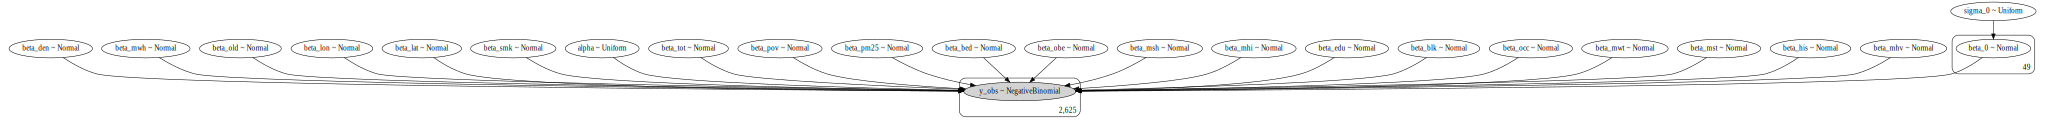

In [7]:
# Visualize Bayesian network
pm.model_to_graphviz(p1_model)

In [8]:
# Sampling
with p1_model:
    p1_trace = pm.sample(3000, init='adapt_diag', tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_tot, beta_lon, beta_lat, beta_mwh, beta_msh, beta_mwt, beta_mst, beta_bed, beta_smk, beta_obe, beta_occ, beta_mhv, beta_edu, beta_his, beta_blk, beta_mhi, beta_pov, beta_old, beta_den, beta_pm25, beta_0, sigma_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [1:21:38<00:00,  1.48draws/s]     
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8810310045465753, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_

In [19]:
# Summary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pm.summary(p1_trace))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_0[0],-0.128,0.244,-0.598,0.314,0.004,0.003,3274.0,3274.0,3276.0,6230.0,1.0
beta_0[1],-0.725,0.269,-1.229,-0.215,0.005,0.003,3460.0,3396.0,3463.0,5946.0,1.0
beta_0[2],0.920,0.389,0.187,1.655,0.005,0.004,5093.0,4826.0,5163.0,6221.0,1.0
beta_0[3],-0.837,0.528,-1.822,0.144,0.010,0.007,2815.0,2815.0,2819.0,5249.0,1.0
beta_0[4],0.984,0.263,0.472,1.456,0.004,0.003,3582.0,3486.0,3617.0,6012.0,1.0
beta_0[5],0.820,0.415,0.033,1.586,0.005,0.004,6572.0,6551.0,6589.0,8374.0,1.0
beta_0[6],-0.109,0.706,-1.373,1.278,0.006,0.007,12493.0,5293.0,12688.0,7057.0,1.0
beta_0[7],0.467,0.495,-0.436,1.414,0.005,0.004,10229.0,7743.0,10369.0,8462.0,1.0
beta_0[8],-0.163,0.344,-0.801,0.484,0.006,0.004,2997.0,2997.0,3007.0,5450.0,1.0
beta_0[9],0.325,0.217,-0.092,0.727,0.004,0.003,2491.0,2491.0,2490.0,4748.0,1.0


/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't

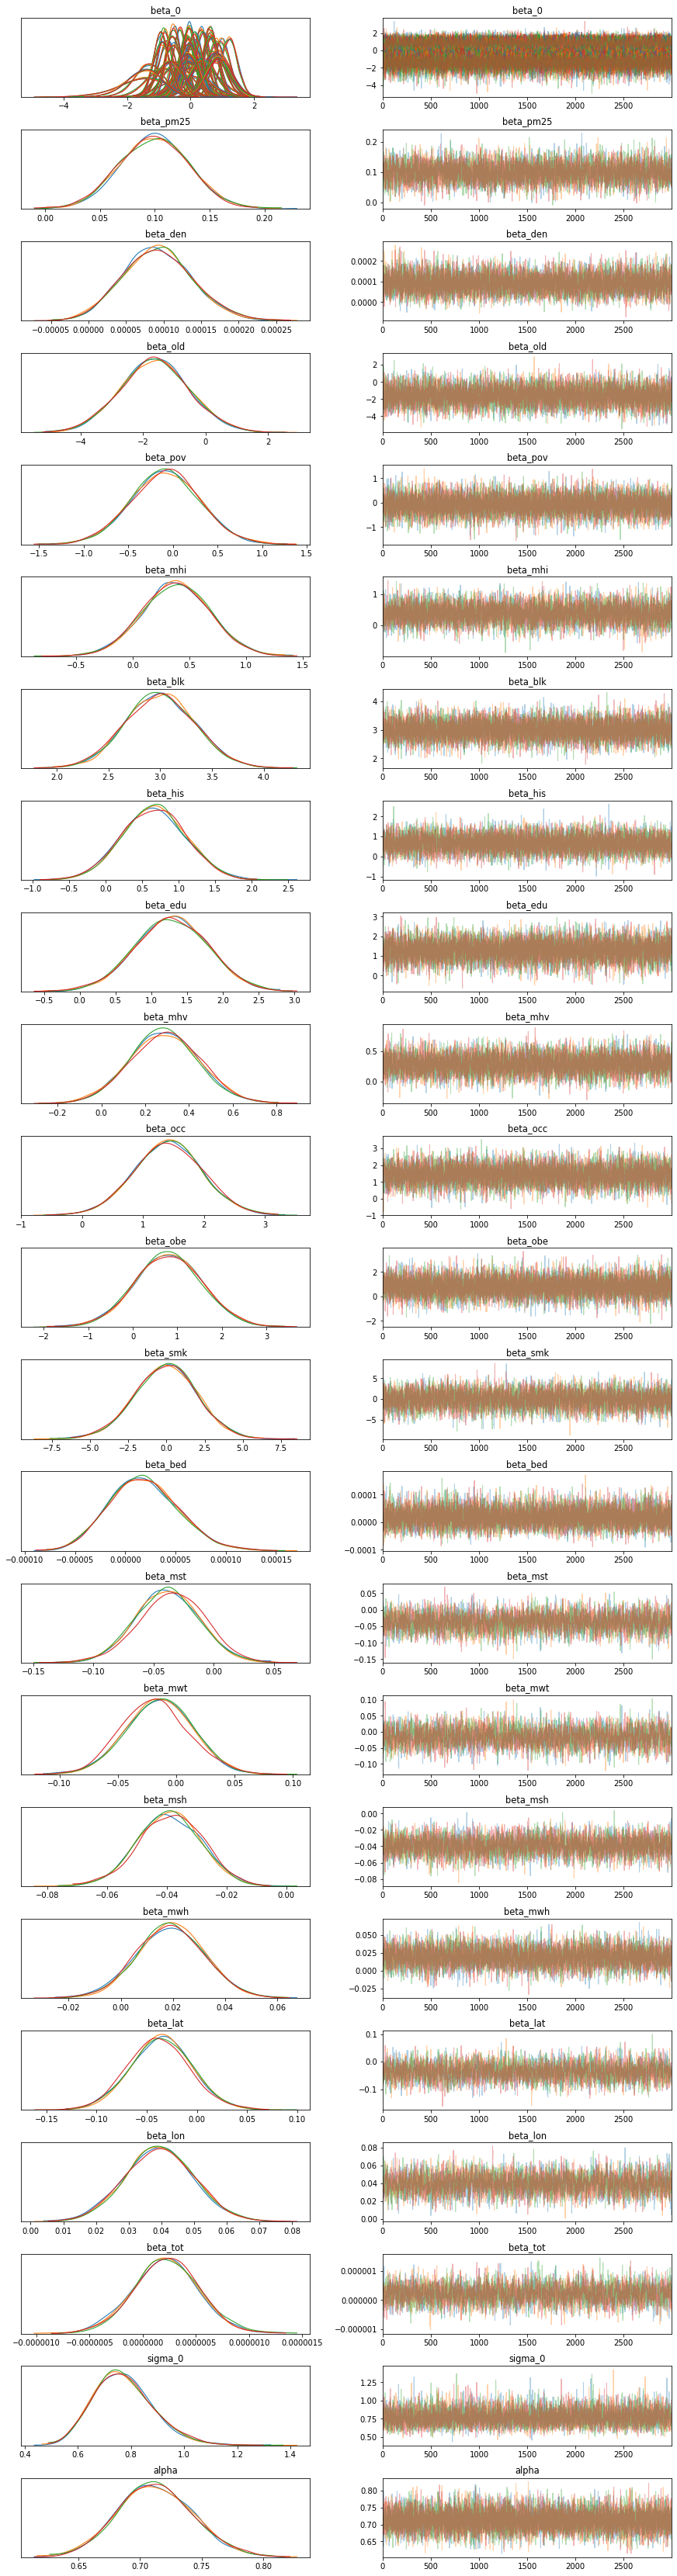

In [10]:
# Traceplots
pm.plots.traceplot(p1_trace)
plt.show()

## Model 2. P2 (a la MacLehose)

Again, we propose a model that the number of deaths in county $i$, $y_i$, follows a negative binomial regression model with mean $\mu_i$ and Gamma parameter $\alpha$, such that $y_i \sim \textrm{NBin} (\mu_i, \alpha)$. We also assume a uniform prior for $\alpha$, and that: $$\mu_i = c_i \exp \eta_i, \eta_i = \beta_{0j} + \sum_k \beta_k x_{ik}$$
Where $c_i$ is the population of county $i$. We assume a random intercept based on state $j$ where $\beta_{0j} \sim \mathcal{N} (0, \sigma_0)$ are drawn from the same normal distribution (since Wu et al. showed that counties within the same state are correlated with one another), with a Half-Cauchy prior for $\sigma_0$. Furthermore, let $\beta_{k} \sim \mathcal{N} (\mu_k, \sigma_k)$, with $\mu_k \sim \mathcal{N} (\theta_k, \omega_k)$, and let $\sigma_k^2 \sim \textrm{IGamma} (\alpha_{1k}, \alpha_{2k})$.

In [12]:
# Fit model to training data
with pm.Model() as p2_model:
    
    # Priors for random intercept
    sigma_0 = pm.Uniform('sigma_0', 0, 10)
    beta_0 = pm.Normal('beta_0', mu=np.repeat(0,len(set(x_state))), 
                       sd=np.repeat(sigma_0,len(set(x_state))), shape=len(set(x_state)))
    
    # Priors for coefficient parameters
    mu_k = pm.Normal('mu', mu=np.repeat(0,20), sd=np.repeat(100,20), shape=20)
    sigma_k = pm.InverseGamma('sigma_k', alpha=np.repeat(1,20), beta=np.repeat(1,20), shape=20)
    
    # Priors for linear terms
    beta_pm25 = pm.Normal('beta_pm25', mu=mu_k[0], sd=np.sqrt(sigma_k[0])) #Pm2.5 
    beta_den = pm.Normal('beta_den', mu=mu_k[1], sd=np.sqrt(sigma_k[1]))   #Population density
    beta_old = pm.Normal('beta_old', mu=mu_k[2], sd=np.sqrt(sigma_k[2]))   #Older percent
    beta_pov = pm.Normal('beta_pov', mu=mu_k[3], sd=np.sqrt(sigma_k[3]))   #Poverty rate
    beta_mhi = pm.Normal('beta_mhi', mu=mu_k[4], sd=np.sqrt(sigma_k[4]))   #Med hh income
    beta_blk = pm.Normal('beta_blk', mu=mu_k[5], sd=np.sqrt(sigma_k[5]))   #Percent black
    beta_his = pm.Normal('beta_his', mu=mu_k[6], sd=np.sqrt(sigma_k[6]))   #Percent hispanic
    beta_edu = pm.Normal('beta_edu', mu=mu_k[7], sd=np.sqrt(sigma_k[7]))   #Percent with less than HS education
    beta_mhv = pm.Normal('beta_mhv', mu=mu_k[8], sd=np.sqrt(sigma_k[8]))   #Med home value
    beta_occ = pm.Normal('beta_occ', mu=mu_k[9], sd=np.sqrt(sigma_k[9]))   #Percent owner-occupied housing
    beta_obe = pm.Normal('beta_obe', mu=mu_k[10], sd=np.sqrt(sigma_k[10]))   #Obesity
    beta_smk = pm.Normal('beta_smk', mu=mu_k[11], sd=np.sqrt(sigma_k[11]))   #Smoke rate
    beta_bed = pm.Normal('beta_bed', mu=mu_k[12], sd=np.sqrt(sigma_k[12]))   #N. beds
    beta_mst = pm.Normal('beta_mst', mu=mu_k[13], sd=np.sqrt(sigma_k[13]))   #Mean summer temperature
    beta_mwt = pm.Normal('beta_mwt', mu=mu_k[14], sd=np.sqrt(sigma_k[14]))   #Mean winter temprerature
    beta_msh = pm.Normal('beta_msh', mu=mu_k[15], sd=np.sqrt(sigma_k[15]))   #Mean summer relative humidity
    beta_mwh = pm.Normal('beta_mwh', mu=mu_k[16], sd=np.sqrt(sigma_k[16]))   #Mean winter relative humditiy
    beta_lat = pm.Normal('beta_lat', mu=mu_k[17], sd=np.sqrt(sigma_k[17]))   #Latitude
    beta_lon = pm.Normal('beta_lon', mu=mu_k[18], sd=np.sqrt(sigma_k[18]))   #Longitude
    beta_tot = pm.Normal('beta_tot', mu=mu_k[19], sd=np.sqrt(sigma_k[19]))   #Total n. tests

    # Finding eta
    eta = beta_0[x_state] + beta_pm25*x_pm25 + beta_den*x_den + beta_old*x_old + beta_pov*x_pov \
            + beta_pov*x_pov + beta_mhi*x_mhi + beta_blk*x_blk + beta_his*x_his + beta_edu*x_edu \
            + beta_mhv*x_mhv + beta_occ*x_occ + beta_obe*x_obe + beta_smk*x_smk + beta_bed*x_bed \
            + beta_mst*x_mst + beta_mwt*x_mwt + beta_msh*x_msh + beta_mwh*x_mwh + beta_lat*x_lat \
            + beta_lon*x_lon + beta_tot*x_tot
    
    # Prior for spread
    alpha = pm.Uniform('alpha', 0, 100)
    
    # Sample from Negative Binomial distribution to find number of deaths
    y_obs = pm.distributions.discrete.NegativeBinomial('y_obs', mu=x_pop*np.exp(eta), 
                                                       alpha=alpha, observed=y_train)

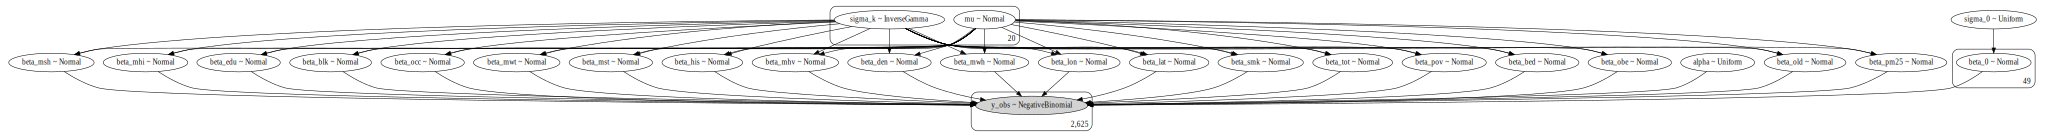

In [13]:
# Visualize Bayesian network
pm.model_to_graphviz(p2_model)

In [14]:
# Sampling
with p2_model:
    p2_trace = pm.sample(3000, init='adapt_diag', tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_tot, beta_lon, beta_lat, beta_mwh, beta_msh, beta_mwt, beta_mst, beta_bed, beta_smk, beta_obe, beta_occ, beta_mhv, beta_edu, beta_his, beta_blk, beta_mhi, beta_pov, beta_old, beta_den, beta_pm25, sigma_k, mu, beta_0, sigma_0]
Sampling 4 chains, 1 divergences: 100%|██████████| 16000/16000 [1:15:45<00:00,  1.11draws/s]     
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.879838431149653, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, incr

In [17]:
# Summary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pm.summary(p2_trace))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_0[0],-0.139,0.247,-0.615,0.306,0.004,0.003,3429.0,3429.0,3426.0,5626.0,1.00
beta_0[1],-0.738,0.274,-1.256,-0.235,0.004,0.003,3738.0,3738.0,3737.0,5852.0,1.00
beta_0[2],0.910,0.382,0.214,1.643,0.005,0.004,5796.0,5583.0,5832.0,7227.0,1.00
beta_0[3],-0.862,0.536,-1.856,0.141,0.009,0.007,3287.0,3287.0,3297.0,5798.0,1.00
beta_0[4],0.977,0.260,0.466,1.444,0.004,0.003,4430.0,4291.0,4442.0,6193.0,1.00
beta_0[5],0.823,0.420,0.045,1.625,0.005,0.004,7413.0,6989.0,7442.0,7755.0,1.00
beta_0[6],-0.118,0.701,-1.449,1.189,0.006,0.007,13164.0,5584.0,13299.0,8632.0,1.00
beta_0[7],0.471,0.503,-0.520,1.369,0.005,0.004,9170.0,6777.0,9405.0,7446.0,1.00
beta_0[8],-0.177,0.342,-0.818,0.462,0.006,0.004,3350.0,3350.0,3350.0,5542.0,1.00
beta_0[9],0.316,0.214,-0.076,0.725,0.004,0.003,2820.0,2820.0,2823.0,5571.0,1.00


/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't

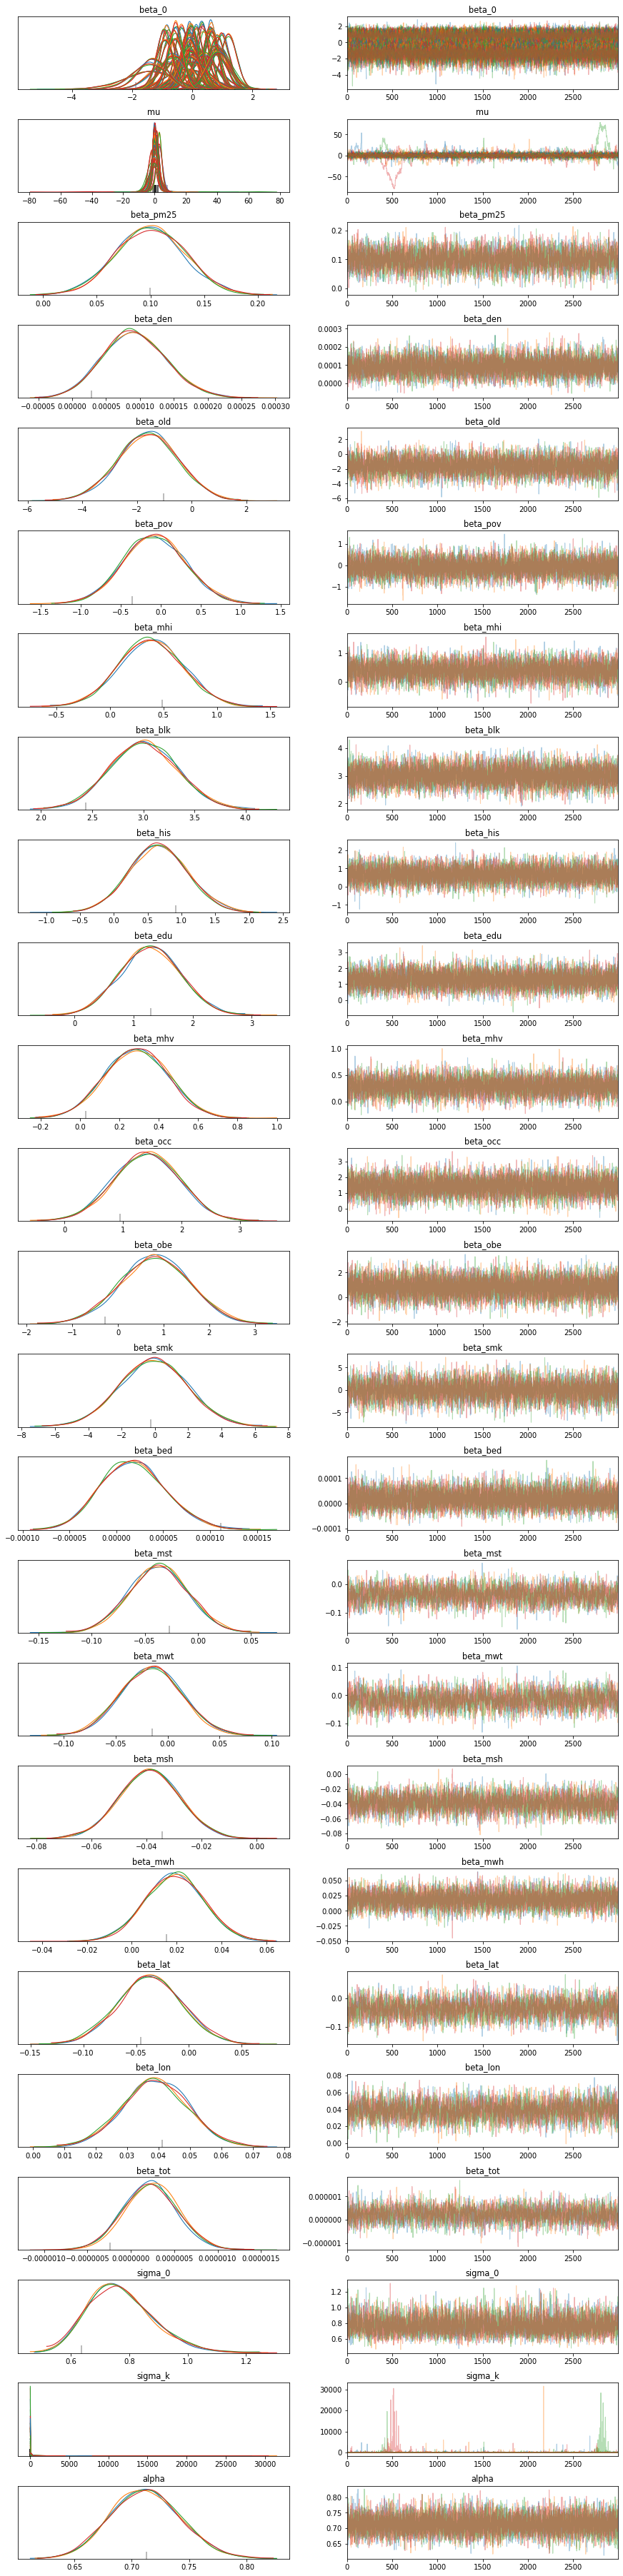

In [18]:
# Traceplots
pm.plots.traceplot(p2_trace)
plt.show()